In [1]:
'''Testing how I want to do the new subgrid calculator'''

import sys
import numpy as np
import time
import matplotlib.pyplot as plt
import re

sys.path.append(r'C:\Users\jwoodruff\Documents\GitHub\subgridADCIRCUtility')

import subgrid_preprocessor_testing as sc

In [2]:
# first read in the control file
        
controlFile = r'C:\Users\jwoodruff\Desktop\subgrid_paper\GBAY_subgrid_example\test_new_subgrid_calculator\subgridControlAllDEMS.txt'
        
with open(controlFile) as ctrF:
            
    ctrF.readline()
    # change to shintaros r.strip with re to allow for spaces
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    # get output file name
    outputFilename = line[1]
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    # get mesh filename
    meshFilename = line[1]
    # read in mannings stuff
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    defaultManning = line[1] # if true just use the manning table in the code
    if defaultManning == 'False': # otherwise we need to read a table in
        line = ctrF.readline().rstrip()
        line = re.split(' *= *',line)
        manningsnTableFilename = line[1] # get the mannings n table filename
    # now read in the elevation array
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    minSurElev = float(line[1])
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    maxSurElev = float(line[1])
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    elevDisc = float(line[1])
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    numDEMs = int(line[1])
    # get list of elevation datasets
    demFilenameList = []
    for i in range(numDEMs):
        line = ctrF.readline().rstrip()
        line = re.split(' *= *',line)
        demFilenameList.append(line[0])
    line = ctrF.readline().rstrip()
    line = re.split(' *= *',line)
    numLCs = int(line[1])
    # get list of landcover datasets
    landcoverFilenameList = []
    for i in range(numLCs):
        line = ctrF.readline().rstrip()
        line = re.split(' *= *',line)
        landcoverFilenameList.append(line[0])
# get table to convert landcover values (possibly just make a function)
if defaultManning:
            
    landCoverToManning = {0:0.02, 2:0.15, 3:0.10, 4:0.05, 5:0.02,
                        6:0.037, 7:0.033, 8:0.034, 9:0.1, 10:0.11,
                        11:0.1, 12:0.05, 13:0.1, 14:0.048, 15:0.045,
                        16:0.1, 17:0.048, 18:0.045, 19:0.04,
                        20:0.09, 21:0.02, 22:0.015, 23:0.015, 
                        24:0.09, 25:0.01}
                
else:
                
    landCoverToManning = sc.subgridCalculatormain.readManning(manningsnTableFilename)

landCoverValues = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25]

# surface elevation array for calcuations
surfaceElevations = np.round(np.arange(minSurElev,maxSurElev+elevDisc,
                                        elevDisc),2).astype('float32') 
num_SfcElevs = len(surfaceElevations)

In [3]:
# now read in the mesh 
# meshFilename = r'C:\Users\jwoodruff\Desktop\subgrid_paper\simulations\SABv3-1000m\fort.14'
mesh = sc.subgridCalculatormain.readMesh(meshFilename)    
meshConnectivity = mesh[1].triangles
meshLon = np.asarray(mesh[0]['Longitude']).astype('float32')
meshLat = np.asarray(mesh[0]['Latitude']).astype('float32')
numNode = mesh[2]
numEle = mesh[3]


# xS = np.vstack((np.asarray(mesh[0]['Longitude'])[meshConnectivity[:,0]],
#                 np.asarray(mesh[0]['Longitude'])[meshConnectivity[:,1]],
#                 np.asarray(mesh[0]['Longitude'])[meshConnectivity[:,2]])).T
        
# yS = np.vstack((np.asarray(mesh[0]['Latitude'])[meshConnectivity[:,0]],
#                 np.asarray(mesh[0]['Latitude'])[meshConnectivity[:,1]],
#                 np.asarray(mesh[0]['Latitude'])[meshConnectivity[:,2]])).T

In [4]:
# for each vertex find what elements it is connected to

# first mind the maximum number of elements connected to a vertex 
# find most common vertex in connectivity table
counts = np.bincount(meshConnectivity.flatten())
commonVertex = np.argmax(counts)
maxConnectedVertex = np.count_nonzero(meshConnectivity==commonVertex)
# create array to hold all the vertex sub area data
# 8 is used because each sub area will have 4 vertices so listing lon then lat
# vertexData = (np.ones((numNode,maxConnectedVertex,8))*-99999).astype('float32')
vertexData = np.empty((numNode,maxConnectedVertex,8))
vertexData[:,:,:] = np.nan
# create an array for vertex sub area sizes 
# vertexSubArea = np.empty((numNode,maxConnectedVertex))
# vertexSubArea[:,:] = np.nan
# allocate vertex variable arrays 
# wetFractionData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# wetFractionData[:,:,:] = np.nan
# totWatDepthData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# totWatDepthData[:,:,:] = np.nan
# wetTotWatDepthData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# wetTotWatDepthData[:,:,:] = np.nan
# cfData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# cfData[:,:,:] = np.nan
# cmfData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# cmfData[:,:,:] = np.nan
# cadvData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# cadvData[:,:,:] = np.nan
# rvData = np.empty((numNode,maxConnectedVertex,num_SfcElevs))
# rvData[:,:,:] = np.nan

# fill this vertex Data Array
for i in range(numNode):
# for i in range(1):
    # find connected elements (this is the slowest part)
    connectedElements = np.where(meshConnectivity==i)[0]
    # fill in vertex data
    for j in range(len(connectedElements)):
        # get vertices of subelement
        ele = connectedElements[j]
        # other vertices 
        otherVertices = meshConnectivity[ele,meshConnectivity[ele,:]!=i]
        # order vertices how you want
        # start with vertex in question
        nm0 = i
        nm1 = otherVertices[0]
        nm2 = otherVertices[1]
        # get lon and lat of vertices
        vertexNumbers = [nm0,nm1,nm2]
        vertexLon = meshLon[vertexNumbers]
        vertexLat = meshLat[vertexNumbers]
        # now get the centroid of the element
        centroidLon = (vertexLon[0]+vertexLon[1]+vertexLon[2])/3
        centroidLat = (vertexLat[0]+vertexLat[1]+vertexLat[2])/3
        # get mid point of each vertex connected to vertex of interest
        midPointLon1 = (meshLon[nm0]+meshLon[nm1])/2
        midPointLon2 = (meshLon[nm0]+meshLon[nm2])/2
        midPointLat1 = (meshLat[nm0]+meshLat[nm1])/2
        midPointLat2 = (meshLat[nm0]+meshLat[nm2])/2
        # now add this data to vertex array
        subAreaPerimeter = np.array((meshLon[nm0],midPointLon1,centroidLon,midPointLon2,
                                     meshLat[nm0],midPointLat1,centroidLat,midPointLat2))
        vertexData[i,j,:] = subAreaPerimeter

# get an array of max and min vertex area coordinates
vertexAreaMinLon = np.nanmin(vertexData[:,:,:4],axis=(1,2))
vertexAreaMaxLon = np.nanmax(vertexData[:,:,:4],axis=(1,2))
vertexAreaMinLat = np.nanmin(vertexData[:,:,4:],axis=(1,2))
vertexAreaMaxLat = np.nanmax(vertexData[:,:,4:],axis=(1,2))


In [79]:
# preallocate arrays to store vertex subgrid data
# areaTotalVertex = np.empty(numNode)
# areaTotalVertex[:] = np.nan
wetFractionVertex = np.empty((numNode,num_SfcElevs))
wetFractionVertex[:,:] = np.nan
totWatDepthVertex = np.empty(wetFractionVertex.shape)
totWatDepthVertex[:,:] = np.nan
wetTotWatDepthVertex = np.empty(wetFractionVertex.shape)
wetTotWatDepthVertex[:,:] = np.nan
cfVertex = np.empty(wetFractionVertex.shape)
cfVertex[:,:] = np.nan
cmfVertex = np.empty(wetFractionVertex.shape)
cmfVertex[:,:] = np.nan
cadvVertex = np.empty(wetFractionVertex.shape)
cadvVertex[:,:] = np.nan
# create a list of vertices contained within the subgrid area
vertexUseList = np.ones(numNode,dtype=bool)
# keep track of total calc time
startTotal = time.time()
for i in range(len(demFilenameList)):
# for i in range(1):
    # reading in DEM again
    # all variables the same as before
    elevationData = sc.subgridCalculatormain.importDEMv2(demFilenameList[i])
    landcoverData = sc.subgridCalculatormain.importDEMv2(landcoverFilenameList[i])
            
    bathyTopo = elevationData[0].astype('float32')
    lonRes = elevationData[1]
    latRes = -1*elevationData[2]
    lon = elevationData[3]
    lat = elevationData[4]
    elevationData = None # deallocate 
    manningsn = landcoverData[0].astype('float32') # array of mannings n values
    landcoverData = None # deallocate

    # # convert raster lon,lat to meshgrid
    # lonGrid,latGrid = np.meshgrid(lon,lat)
            
    for value in landCoverValues:
            
        manningsn[manningsn == value] = landCoverToManning[value]
            
    # set nan values to 0.02
            
    manningsn[np.isnan(manningsn)] = 0.02
    # create a buffer for containment
    # bufferCells = 3
    bufferLon = lonRes# *bufferCells
    bufferLat = latRes# *bufferCells
    # get bounds of raster data
    demMinLon = np.min(lon)
    demMaxLon = np.max(lon)
    demMinLat = np.min(lat)
    demMaxLat = np.max(lat)

    # see what vertices lie within this dem
    minLonWithin = np.array(vertexAreaMinLon>demMinLon)
    maxLonWithin = np.array(vertexAreaMaxLon<demMaxLon)
    minLatWithin = np.array(vertexAreaMinLat>demMinLat)
    maxLatWithin = np.array(vertexAreaMaxLat<demMaxLat)
    # get all within and only use vertices that have not already been used
    allWithin = minLonWithin*maxLonWithin*minLatWithin*maxLatWithin*vertexUseList
    idxAllWithin = np.where(allWithin)[0]
    # update vertex use list 
    vertexUseList[idxAllWithin] = False

    # now loop through contained vertices and perform calculations
    # for vertex in idxAllWithin:
    for j in range(len(idxAllWithin)):
    # for j in range(1):
        start = time.time()
        # find how many connected elements
        conElementCount = np.count_nonzero(~np.isnan(vertexData[idxAllWithin[j],:,0])) 
        # create array to hold vertex area data 
        vertexSubArea = np.zeros((conElementCount,1))
        # temporarily allocate for each subarea
        tempwetFractionData = np.zeros((conElementCount,num_SfcElevs))
        # just set the rest equal to this because we are just preallocating 0 arrays
        temptotWatDepthData = np.zeros((conElementCount,num_SfcElevs)) # tempwetFractionData
        tempwetTotWatDepthData = np.zeros((conElementCount,num_SfcElevs)) # tempwetFractionData
        tempcfData = np.zeros((conElementCount,num_SfcElevs)) # tempwetFractionData
        tempcmfData = np.zeros((conElementCount,num_SfcElevs)) # tempwetFractionData
        tempcadvData = np.zeros((conElementCount,num_SfcElevs)) # tempwetFractionData
        # temprvData = temptotWatDepthData
        # now loop through connected elements
        for k in range(conElementCount):
        # for k in range(1):
            # get the sub area perimeter for the particular element
            subAreaPerimeterLon = vertexData[idxAllWithin[j],k,:4]
            subAreaPerimeterLat = vertexData[idxAllWithin[j],k,4:]
            # cut down dem and landcover to each sub area
            # get locations of bounds
            minLonDEMWithin = lon > np.min(subAreaPerimeterLon)
            maxLonDEMWithin = lon < np.max(subAreaPerimeterLon)
            lonWithinIdx = np.where(minLonDEMWithin*maxLonDEMWithin)[0]
            minCol = np.min(lonWithinIdx)#  - bufferCells # create a cell buffer
            maxCol = np.max(lonWithinIdx)#  + bufferCells
            demLonCut = lon[minCol:maxCol]
            minLatDEMWithin = lat > np.min(subAreaPerimeterLat)
            maxLatDEMWithin = lat < np.max(subAreaPerimeterLat)
            latWithinIdx = np.where(minLatDEMWithin*maxLatDEMWithin)[0]
            minRow = np.min(latWithinIdx)#  - bufferCells # create a 3 cell buffer
            maxRow = np.max(latWithinIdx)#  + bufferCells
            demLatCut = lat[minRow:maxRow]
            demBathyTopoCut = bathyTopo[minRow:maxRow,minCol:maxCol]
            manningsnCut = manningsn[minRow:maxRow,minCol:maxCol]
            lonGrid,latGrid = np.meshgrid(demLonCut,demLatCut)

            # split into 2 triangles
                
            triLon0 = subAreaPerimeterLon[:3]
            triLat0 = subAreaPerimeterLat[:3]
                    
            # convert to meters
            tri0Meters = sc.subgridCalculatormain.projectMeshToMercator(triLat0,
                                                                      triLon0)
            tri0Area = sc.subgridCalculatormain.triarea(tri0Meters[0][0], 
                                                    tri0Meters[1][0],
                                                    tri0Meters[0][1], 
                                                    tri0Meters[1][1],
                                                    tri0Meters[0][2], 
                                                    tri0Meters[1][2])

                    
            insideTri0 = sc.subgridCalculatormain.isInside(triLon0[0], triLat0[0],
                                                            triLon0[1], triLat0[1],
                                                            triLon0[2], triLat0[2],
                                                            lonGrid, latGrid, 0.00000001)
                    
            triLon1 = subAreaPerimeterLon[[0,2,3]]
            triLat1 = subAreaPerimeterLat[[0,2,3]]
            tri1Meters = sc.subgridCalculatormain.projectMeshToMercator(triLat1,
                                                                      triLon1)

                    
            tri1Area = sc.subgridCalculatormain.triarea(tri1Meters[0][0], 
                                                        tri1Meters[1][0],
                                                        tri1Meters[0][1], 
                                                        tri1Meters[1][1],
                                                        tri1Meters[0][2], 
                                                        tri1Meters[1][2])
                    
                    
            insideTri1 = sc.subgridCalculatormain.isInside(triLon1[0], triLat1[0],
                                                            triLon1[1], triLat1[1],
                                                            triLon1[2], triLat1[2],
                                                            lonGrid, latGrid, 0.00000001)
                    
            # now combine the two triangles and find the points inside
                    
            insideSubElement = np.logical_or(insideTri0,insideTri1)
                    
            # count the number of subgrid cells within the subelement
                    
            cellsInSubElement = np.count_nonzero(insideSubElement)

            # if there are no cells within the element the DEM is too coarse
            # you must decrease the DEM resolution in this area
            if cellsInSubElement == 0:

                sys.exit('DEM {0} resolution too coarse!'.format(i))
                    
            # get just he bathy topo inside the sub element 
                    
            bathyTopoInsideSubElement = demBathyTopoCut*insideSubElement
                    
            # set 0 values to nan for calculations
                    
            bathyTopoInsideSubElement[bathyTopoInsideSubElement==0] = np.nan
                    
            # get area of sub element
                    
            # vertexSubArea[idxAllWithin[j],k] = tri0Area + tri1Area # used for area weighting later
            # fill rest of dim space with area for multiplication later 
            vertexSubArea[k] = tri0Area + tri1Area # used for area weighting later
            # remove cells not inside sub element which will flatten the array
            bathyTopoInsideSubElementNoNaN = bathyTopoInsideSubElement[~np.isnan(bathyTopoInsideSubElement)]
            manningsnCutNoNaN = manningsnCut[~np.isnan(bathyTopoInsideSubElement)]

            # get the total water depth at each surface elevation
                    
            temptotWatDepth =  surfaceElevations[:,None] - bathyTopoInsideSubElementNoNaN
                    
            # count the number of wet cells
                    
            wetCellsInSubArea = temptotWatDepth > 0.0001
                    
            wetCellsInSubAreaCount = np.sum(wetCellsInSubArea,axis=1).astype('float32')

            # now set tot water depth of dry cells to nan
                    
            temptotWatDepth[temptotWatDepth < 0.0001] = np.nan
    
            # add to wet frac array
                    
            tempwetFractionData[k,:] = wetCellsInSubAreaCount/cellsInSubElement

            # add to total water depth array
            # I think I can get away with setting everything dry to 0 and not using nansum                       
            # temptotWatDepthData[k,:] = np.nansum(temptotWatDepth,axis=1)/cellsInSubElement
            temptotWatDepthData[k,:] = np.nansum(temptotWatDepth,axis=1)/cellsInSubElement

            # get wet total water depth and coefficient of friction
                    
            # find the mannings for only wet areas then 0 the rest for 
            # use in calculations 
                    
            manningsnCutNoNaNWet = manningsnCutNoNaN * wetCellsInSubArea
                    
            tempcf = (9.81*manningsnCutNoNaNWet**2)/(temptotWatDepth**(1/3))
            # set 0 tempcf to nan to prevent 0 divide
            tempcf[tempcf==0] = np.nan

            # make wet cells in sub area count nan when == 0 so we don't get divide by 0 issue
            wetCellsInSubAreaCount[wetCellsInSubAreaCount==0.0] = np.nan
            # set temptotWatDepth 0 values to nan to avoid true divide
            # temptotWatDepthData[k,temptotWatDepthData[k,:]==0.0] = np.nan
            # calculate wet total water depth
            tempwetTotWatDepthData[k,:] = np.nansum(temptotWatDepth,axis=1)/wetCellsInSubAreaCount
            # calculate bottom friction coefficient
            tempcfData[k,:]= np.nansum(tempcf,axis=1)/wetCellsInSubAreaCount
            # calculate rv for use in advection and bottom friction correction
            rv = tempwetTotWatDepthData[k,:]/(np.nansum((temptotWatDepth**(3/2))*(tempcf**(-1/2)),axis=1)/wetCellsInSubAreaCount)
            # calcualte advection correction
            tempcadvData[k,:] = (1/tempwetTotWatDepthData[k,:])*(np.nansum(temptotWatDepth**2/tempcf,axis=1)/wetCellsInSubAreaCount)*rv**2
            # calculate bottom friction correction
            tempcmfData[k,:] = tempwetTotWatDepthData[k,:]*rv**2 # this is correct I need <H>W * Rv**2
            # now fill the nans from this calculation which represent depths were nothing was wet
            # set wet total water depth to 0
            tempwetTotWatDepthData[k,np.isnan(tempwetTotWatDepthData[k,:])] = 0.0
            tempwetTotWatDepthData[k,np.isnan(tempwetTotWatDepthData[k,:])] = 0.0
            # set nan values to cf calculated from mean mannings n and 8 cm of water
            tempcfData[k,np.isnan(tempcfData[k,:])] = 9.81*np.mean(manningsnCutNoNaN)**2/(0.08**(1/3))
            tempcmfData[k,np.isnan(tempcmfData[k,:])] = 9.81*np.mean(manningsnCutNoNaN)**2/(0.08**(1/3))
            # set advection correction equal to 1.0
            tempcadvData[k,np.isnan(tempcadvData[k,:])] = 1.0
        
        # once the sub elements surrounding each vertex have been looped through, put all of he data on the elements
        areaTotalVertex = np.sum(vertexSubArea[:,0])
  
        # check = np.sum(tempwetFractionData*vertexSubArea,axis=0)/areaTotalVertex
        wetFractionVertex[idxAllWithin[j],:] = np.sum(tempwetFractionData*vertexSubArea,axis=0)/areaTotalVertex
        totWatDepthVertex[idxAllWithin[j],:] = np.sum(temptotWatDepthData*vertexSubArea,axis=0)/areaTotalVertex
        wetTotWatDepthVertex[idxAllWithin[j],:] = np.sum(tempwetTotWatDepthData*vertexSubArea,axis=0)/areaTotalVertex
        cfVertex[idxAllWithin[j],:] = np.sum(tempcfData*vertexSubArea,axis=0)/areaTotalVertex
        cmfVertex[idxAllWithin[j],:] = np.sum(tempcmfData*vertexSubArea,axis=0)/areaTotalVertex
        cadvVertex[idxAllWithin[j],:] = np.sum(tempcadvData*vertexSubArea,axis=0)/areaTotalVertex
        # finish vertex loop and print time
        end = time.time()
        print('Finish vertex {} in DEM {} took : {} s'.format(idxAllWithin[j],i,end-start))

# set minimums for bottom friction
cfVertex[cfVertex<0.0025] = 0.0025
cmfVertex[cmfVertex<0.0025] = 0.0025
# total time
endTotal = time.time()
print('All calulations took {} s'.format(endTotal-startTotal))




Finish vertex 5958 in DEM 0 took : 0.01199960708618164 s
Finish vertex 5959 in DEM 0 took : 0.007000446319580078 s
Finish vertex 5963 in DEM 0 took : 0.009999752044677734 s
Finish vertex 5965 in DEM 0 took : 0.010999917984008789 s
Finish vertex 5966 in DEM 0 took : 0.007999897003173828 s
Finish vertex 6108 in DEM 0 took : 0.01100015640258789 s
Finish vertex 6109 in DEM 0 took : 0.008999824523925781 s
Finish vertex 6110 in DEM 0 took : 0.0070002079010009766 s
Finish vertex 6111 in DEM 0 took : 0.009999752044677734 s
Finish vertex 6112 in DEM 0 took : 0.0070002079010009766 s
Finish vertex 6113 in DEM 0 took : 0.010001897811889648 s
Finish vertex 6114 in DEM 0 took : 0.008997678756713867 s
Finish vertex 6115 in DEM 0 took : 0.009999990463256836 s
Finish vertex 6116 in DEM 0 took : 0.009999752044677734 s
Finish vertex 6118 in DEM 0 took : 0.006000041961669922 s
Finish vertex 6119 in DEM 0 took : 0.006999969482421875 s
Finish vertex 6120 in DEM 0 took : 0.006999969482421875 s
Finish vertex 

In [27]:
# # now condense all of the of the subareas to each vertices 
# areaTotalVertex = np.empty(numNode)
# areaTotalVertex[:] = np.nan
# wetFractionVertex = np.empty((numNode,num_SfcElevs))
# wetFractionVertex[:,:] = np.nan
# totWatDepthVertex = np.empty(wetFractionVertex.shape)
# totWatDepthVertex[:,:] = np.nan
# wetTotWatDepthVertex = np.empty(wetFractionVertex.shape)
# wetTotWatDepthVertex[:,:] = np.nan
# cfVertex = np.empty(wetFractionVertex.shape)
# cfVertex[:,:] = np.nan
# cmfVertex = np.empty(wetFractionVertex.shape)
# cmfVertex[:,:] = np.nan
# cadvVertex = np.empty(wetFractionVertex.shape)
# cadvVertex[:,:] = np.nan
# # rvVertex = np.empty(wetFractionVertex.shape)
# # rvVertex[:,:] = np.nan

# areaTotalVertex = np.nansum(vertexSubArea,axis=1)

# # run through each water surface elevation and get the area averaged vertex quantities
# for i in range(num_SfcElevs):
#     wetFractionVertex[:,i] = np.nansum(wetFractionData[:,:,i]*vertexSubArea[:,:],axis=1)/areaTotalVertex
#     totWatDepthVertex[:,i] = np.nansum(totWatDepthData[:,:,i]*vertexSubArea[:,:],axis=1)/areaTotalVertex
#     wetTotWatDepthVertex[:,i] = np.nansum(wetTotWatDepthData[:,:,i]*vertexSubArea[:,:],axis=1)/areaTotalVertex
#     cfVertex[:,i] = np.nansum(cfData[:,:,i]*vertexSubArea[:,:],axis=1)/areaTotalVertex
#     cmfVertex[:,i] = np.nansum(cmfData[:,:,i]*vertexSubArea[:,:],axis=1)/areaTotalVertex
#     cadvVertex[:,i] = np.nansum(cadvData[:,:,i]*vertexSubArea[:,:],axis=1)/areaTotalVertex

# cadvVertex[np.isnan(cadvVertex)] = 1.0

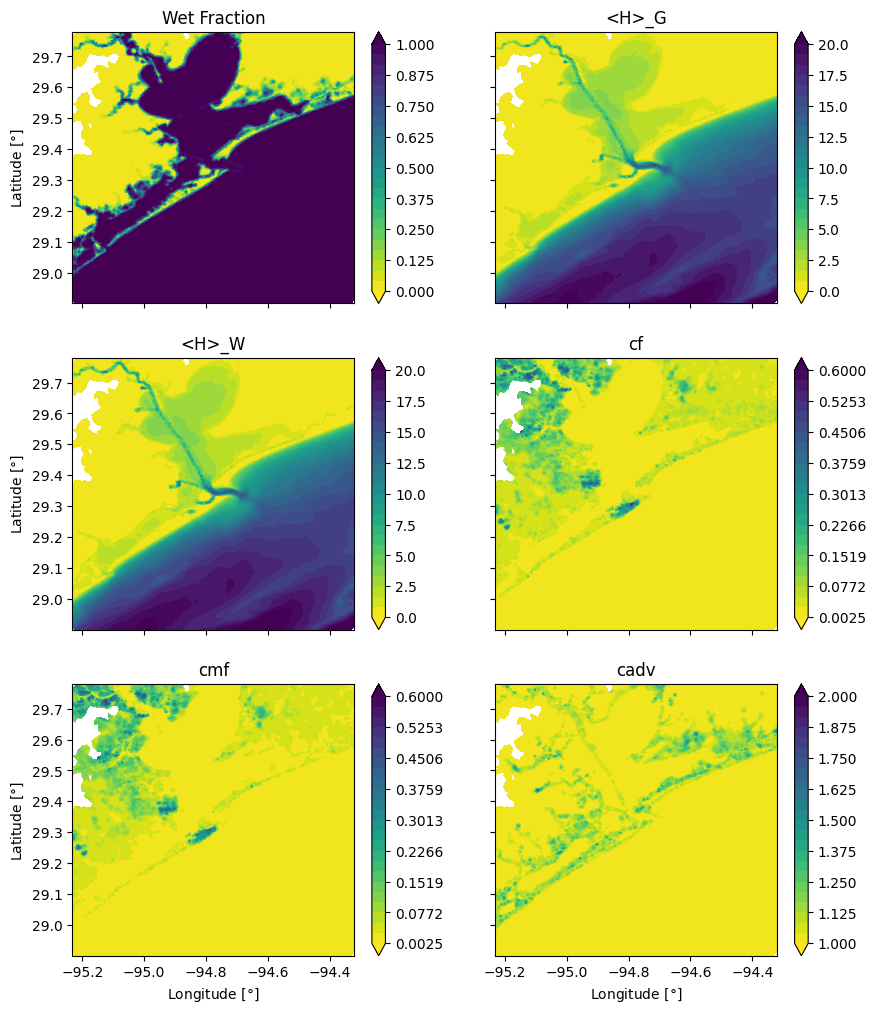

In [92]:
# plot this 
variableList = [wetFractionVertex,totWatDepthVertex,wetTotWatDepthVertex,cfVertex,cmfVertex,cadvVertex]
nameList = ['Wet Fraction','<H>_G','<H>_W','cf','cmf','cadv']
maxValues = [1.0,20.0,20.0,0.6,0.6,2.0]
minValues = [0.0,0.0,0.0,0.0025,0.0025,1.0]
colorLevels = []
for i in range(len(maxValues)):
    colorLevels.append(np.linspace(minValues[i],maxValues[i],25))

count = 0
fig,axs=plt.subplots(3,2,figsize=(10,12),sharex=True,sharey=True)
for i in range(3):
    axs[i,0].set_ylabel('Latitude [$\degree$]')
    for j in range(2):
        ax=axs[i,j]
        ax.set_aspect('equal')
        # im = ax.scatter(mesh[0]['Longitude'],mesh[0]['Latitude'],c=variableList[count][:,50])
        im = ax.tricontourf(mesh[1],variableList[count][:,50],levels=colorLevels[count],
                            extend='both',cmap='viridis_r')
        ax.set_title(nameList[count])
        count+=1
        plt.colorbar(im,ax=ax)

    axs[-1,0].set_xlabel('Longitude [$\degree$]')
    axs[-1,1].set_xlabel('Longitude [$\degree$]')

In [78]:
# print max and min of each dataset
for variable in variableList:
    print(np.max(variable))

1.0
33.810822269587234
33.810822269587234
0.7888628344863766
0.6641358292978206
2.859187435232886
